# Homework 1

This homework relies on the data file, `treasury_quotes_2022-09-30`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `ITYPE` of 11 or 12, as these indicate a TIPS Note or TIPS bond.

In [71]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Problem 1: Explore the Data

## 1 Maturity

For each issue, calculate its time-to-maturity, quoted in number of years, based on the issue and maturity dates. Assume a year has exactly 365.25 days.

In [72]:
QUOTE_DATE = '2022-09-30'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

data_without_TIPS_11 = rawdata[rawdata['ITYPE'] != 11]
data_without_TIPS = data_without_TIPS_11[data_without_TIPS_11['ITYPE'] != 12]

# display(rawdata)
# display(data_without_TIPS)

data_without_TIPS['Time to Maturity'] = ((data_without_TIPS['TMATDT'] - data_without_TIPS['CALDT']).dt.days)/365.25

display(data_without_TIPS[['TMATDT', 'TDATDT', 'Time to Maturity']])

C:\Users\madrs\AppData\Local\Temp\ipykernel_23684\4065376851.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_TIPS['Time to Maturity'] = ((data_without_TIPS['TMATDT'] - data_without_TIPS['CALDT']).dt.days)/365.25


,TMATDT,TDATDT,Time to Maturity
KYTREASNO,,,
207892,2022-10-04,2022-06-07,0.010951
207774,2022-10-06,2021-10-07,0.016427
207893,2022-10-11,2022-06-14,0.030116
207868,2022-10-13,2022-04-14,0.035592
207430,2022-10-15,2019-10-15,0.041068
...,...,...,...
207763,2051-08-15,2021-08-15,28.873374
207808,2051-11-15,2021-11-15,29.125257
207849,2052-02-15,2022-02-15,29.377139


## 2 Prices 

Calculate the "dirty" price for each bond issue as
$$\text{price} = \frac{1}{2}(\text{TDBID} + \text{TDASK}) + \text{TDACCINT}$$
Namely, you are taking the midpoint of the bid and ask prices, and then you add the accrued interest.

In [73]:
data_without_TIPS['Dirty Price'] = 0.5 * (data_without_TIPS['TDBID'] + data_without_TIPS['TDASK']) + data_without_TIPS['TDACCINT']

display(data_without_TIPS[['TDBID', 'TDASK', 'TDACCINT', 'Dirty Price']])

C:\Users\madrs\AppData\Local\Temp\ipykernel_23684\177021958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_TIPS['Dirty Price'] = 0.5 * (data_without_TIPS['TDBID'] + data_without_TIPS['TDASK']) + data_without_TIPS['TDACCINT']


,TDBID,TDASK,TDACCINT,Dirty Price
KYTREASNO,,,,
207892,99.973333,99.973444,0.000000,99.973389
207774,99.960917,99.961083,0.000000,99.961000
207893,99.924986,99.925292,0.000000,99.925139
207868,99.907556,99.907917,0.000000,99.907736
207430,99.921875,99.953125,0.631148,100.568648
...,...,...,...,...
207763,68.085938,68.148438,0.250000,68.367188
207808,65.914062,65.960938,0.703125,66.640625
207849,72.406250,72.468750,0.281250,72.718750


## 3 YTM

Calculate YTM for every bond issue.

In [74]:
# Function for first part of Price equation (all coupons paid before maturity)
def pv(rate, cashflows, maturities, freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

# Function for calculating cashflows
def calc_cashflows(quote_data):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
        
    return CF

# Gets coupon dates
def get_coupon_dates(quote_date,maturity_date):
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out

# Function for getting time to maturity
def get_maturity_delta(t_maturity,t_current):

    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta


In [75]:
current_date = rawdata['CALDT'].values[0]
bond_data = data_without_TIPS.loc[data_without_TIPS['ITYPE'] == 1]

cashflows_for_bonds = calc_cashflows(bond_data)

maturity_grid = pd.Series(get_maturity_delta(cashflows_for_bonds.columns.values,t_current=current_date),index=cashflows_for_bonds.columns)

ytm = pd.Series(index=bond_data.index,dtype=float)
for idbond in bond_data.index:
    pv_wrapper = lambda y: bond_data.loc[idbond]['Dirty Price'] - pv(y,cashflows_for_bonds.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond] = fsolve(pv_wrapper,.01)

bond_data['YTM'] = ytm

display(bond_data['YTM'])

C:\Users\madrs\AppData\Local\Temp\ipykernel_23684\795143222.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_data['YTM'] = ytm


KYTREASNO
204080    0.033816
204081    0.035073
204082    0.042288
204083    0.043198
204084    0.043201
            ...   
207763    0.038357
207808    0.038243
207849    0.038186
207891    0.037994
207934    0.037780
Name: YTM, Length: 88, dtype: float64

## 4 Summary Table

Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYTM | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYTM` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

In [76]:
summary_table_df = pd.DataFrame(index=bond_data.index)
summary_table_df['maturity'] = bond_data['Time to Maturity']
summary_table_df['price'] = bond_data['TDNOMPRC']
summary_table_df['coupon rate'] = bond_data['TCOUPRT']
summary_table_df['ytm'] = bond_data['YTM']
summary_table_df['TDYTM'] = bond_data['TDYLD'] * 365 # Multiplied to get to yearly
summary_table_df['bid-ask'] = bond_data['TDBID'] - bond_data['TDASK']

display(summary_table_df.head())
summary_table_df.describe()

,maturity,price,coupon rate,ytm,TDYTM,bid-ask
KYTREASNO,,,,,,
204080,0.125941,100.515625,7.625,0.033816,0.033510,-0.03125
204081,0.377823,101.320312,7.125,0.035073,0.034745,-0.03125
204082,0.873374,101.718750,6.250,0.042288,0.041818,-0.03125
204083,2.127310,106.375000,7.500,0.043198,0.042709,-0.03125
204084,2.379192,107.359375,7.625,0.043201,0.042712,-0.03125


,maturity,price,coupon rate,ytm,TDYTM,bid-ask
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,18.278919,89.218306,3.694602,0.040271,0.039843,-0.057262
std,8.233607,15.777237,1.657214,0.001668,0.001635,0.013439
min,0.125941,55.835938,1.125000,0.033816,0.033510,-0.093750
25%,15.561259,76.328125,2.500000,0.039108,0.038704,-0.062500
50%,19.500342,86.257812,3.125000,0.040750,0.040313,-0.062500
75%,24.438741,105.597656,4.531250,0.041480,0.041027,-0.046875
max,29.875428,114.953125,7.625000,0.043549,0.043052,-0.031250


## 5 Plots

Create a scatter plot of maturity versus price for all issues.

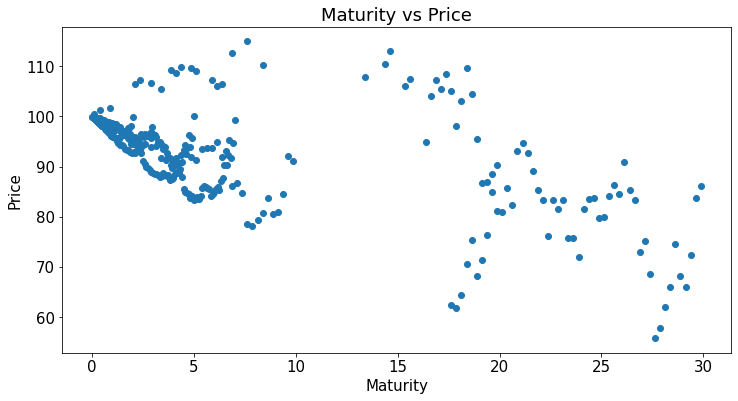

In [77]:
plt.scatter(data_without_TIPS['Time to Maturity'], data_without_TIPS['TDNOMPRC'])
plt.title(f'Maturity vs Price')
plt.ylabel('Price')
plt.xlabel('Maturity')
plt.show()

## 6 Bad Data?

Find the issues where `TDYTM` is `NaN`. Display these rows from your table above. How many issues (rows) are effected?

What do you see in the other metrics for these issues that suggests that the price is bad?

In [78]:
bad_yield_data = rawdata.loc[rawdata['TDYLD'].isna()]

bad_yield_data.head()

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
206582,20230115.C00120,2022-09-30,98.984375,98.992188,98.988281,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207204,20230415.C00620,2022-09-30,98.613281,98.621094,98.617188,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206642,20230715.C00370,2022-09-30,98.382812,98.394531,98.388672,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
206701,20240115.C00620,2022-09-30,97.609375,97.628906,97.619141,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207348,20240415.C00500,2022-09-30,97.109375,97.132812,97.121094,M,I,0.0,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN


These issues are all TIPS...

# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

You will need to make a few modeling choices to do this...
* eliminate any treasury that does not report `TDYTM` or that reports a negative number for `TDYTM`.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [85]:
filtered_data = data_without_TIPS.loc[data_without_TIPS['TDYLD'] > 0]
cashflows_for_all_issues = calc_cashflows(filtered_data)
display(cashflows_for_all_issues)

cashflow_max = cashflows_for_all_issues.sum().sort_values(ascending=False)
print("The date with the most cashflow across all issues is:")
display(cashflow_max.index[0])

issues_with_cashflow = cashflows_for_all_issues[cashflows_for_all_issues > 0].count().sort_values(ascending=False)
print("The date with the most issues paying a cashflow is:")
display(issues_with_cashflow.index[0])

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0


The date with the most cashflow across all issues is:


Timestamp('2023-01-31 00:00:00')

The date with the most issues paying a cashflow is:


Timestamp('2023-02-15 00:00:00')

## 2 Bootstrap

Bootstrap the discount factors.

Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

The three step procedure below might be useful.

1. For dates with multiple bonds maturing, keep only that with the smallest bid-ask. If there are still multiple bonds maturing on the date, keep only that with the smallest coupon.

2. Only keep the first $L$ columns of the cashflow matrix, such that every column has a bond maturing.

3. Eliminate any bonds, (rows,) that had maturity beyond column $L$.

This should produce the cashflow matrix, $\tilde{C}$.

**Report 5 head and tail rows of $\tilde{C}$.**

Solve the system of equations
$$\textbf{p} = \tilde{\textbf{C}}\, \textbf{z}_{\text{bootstrap}}$$

**Plot the estimated discount factors, $\textbf{z}$, against time-to-maturity.**

In [95]:
summary_table_df_2 = pd.DataFrame(index=data_without_TIPS.index)
summary_table_df_2['maturity'] = data_without_TIPS['TMATDT']
summary_table_df_2['price'] = data_without_TIPS['TDNOMPRC']
summary_table_df_2['coupon rate'] = data_without_TIPS['TCOUPRT']
summary_table_df_2['TDYTM'] = data_without_TIPS['TDYLD'] * 365 # Multiplied to get to yearly
summary_table_df_2['bid-ask'] = abs(data_without_TIPS['TDBID'] - data_without_TIPS['TDASK'])

issues_to_keep = []
columns_to_drop = []
    
# Filter by min bid-ask spread
for col in cashflows_for_all_issues.columns:
    issues_with_cashflow_on_day = summary_table_df_2.loc[summary_table_df_2['maturity'] == col]
    if len(issues_with_cashflow_on_day) > 0:
        issue_to_keep = issues_with_cashflow_on_day[['bid-ask']].idxmin()[0]
        issues_to_keep.append(issue_to_keep)
    else:
        columns_to_drop.append(col)

filtered_cashflows = cashflows_for_all_issues.loc[cashflows_for_all_issues.index.isin(issues_to_keep)]
filtered_cashflows = filtered_cashflows.drop(columns_to_drop, axis=1)
display(filtered_cashflows)

# Keep only first L columns that have bond maturing
columns_to_keep = []
for col in cashflows_for_all_issues.columns:
    values = cashflows_for_all_issues[col].values
    if max(values) < 100:
        break
    columns_to_keep.append(col)
    
filtered_cashflows = filtered_cashflows[columns_to_keep]
display(filtered_cashflows)

# Remove any rows past that end date
num_rows_to_keep = len(filtered_cashflows.columns)
filtered_cashflows = filtered_cashflows.iloc[range(num_rows_to_keep)]
display(filtered_cashflows)


,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-31,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0


,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27
KYTREASNO,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0
207774,0,100,0,0,0.0000,0,0,0,0
207893,0,0,100,0,0.0000,0,0,0,0
207868,0,0,0,100,0.0000,0,0,0,0
207430,0,0,0,0,100.6875,0,0,0,0
...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0
207808,0,0,0,0,0.0000,0,0,0,0
207849,0,0,0,0,0.0000,0,0,0,0


,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27
KYTREASNO,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0
207774,0,100,0,0,0.0000,0,0,0,0
207893,0,0,100,0,0.0000,0,0,0,0
207868,0,0,0,100,0.0000,0,0,0,0
207430,0,0,0,0,100.6875,0,0,0,0
207894,0,0,0,0,0.0000,100,0,0,0
207869,0,0,0,0,0.0000,0,100,0,0
207895,0,0,0,0,0.0000,0,0,100,0
207870,0,0,0,0,0.0000,0,0,0,100


In [96]:
# Solve the system of equations, p = Cz
C_inverse = pd.DataFrame(np.linalg.pinv(filtered_cashflows.values), filtered_cashflows.columns, filtered_cashflows.index)
p = summary_table_df_2[summary_table_df_2.index.isin(C_inverse.columns)]['price']
z = np.matmul(C_inverse,p)
display(z)

2022-10-04    0.999734
2022-10-06    0.999610
2022-10-11    0.999251
2022-10-13    0.999077
2022-10-15    0.992551
2022-10-18    0.998777
2022-10-20    0.998597
2022-10-25    0.998257
2022-10-27    0.998073
dtype: float64

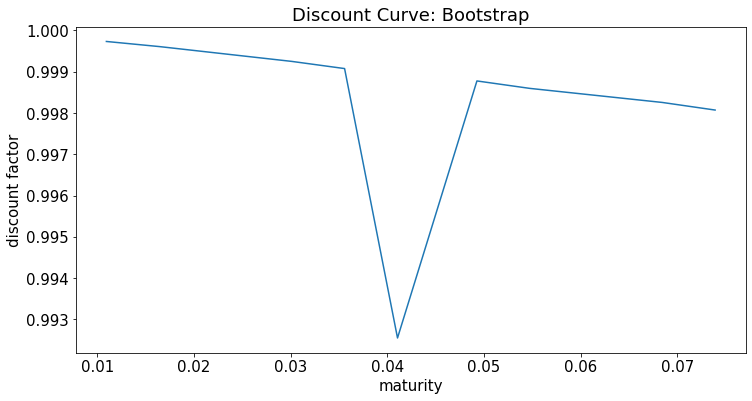

In [97]:
plt.plot(get_maturity_delta(z.index,t_current=current_date),z.values)
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

## 3. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. (You might do something similar to the three-step procedure of the bootstrap, but skip step #1.) Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

**Plot the discount factors against maturities.**

In [83]:
issues_to_keep = []
    
# Filter by min bid-ask spread
for col in cashflows_for_all_issues.columns:
    issues_with_cashflow_on_day = summary_table_df_2.loc[summary_table_df_2['maturity'] == col]
    for i in issues_with_cashflow_on_day.index:
        issues_to_keep.append(i)

filtered_ols_cashflows = cashflows_for_all_issues.loc[cashflows_for_all_issues.index.isin(issues_to_keep)]
display(filtered_ols_cashflows)

mod = LinearRegression(fit_intercept=False).fit(filtered_ols_cashflows.values,p)
print(mod.coef_)
# disc_ols = pd.DataFrame({'maturity':mod[0], 'ols': mod[1]}).set_index('maturity')
# disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
# plt.show()

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207763,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.000,0.0000,1.000,0.0000,101.000,0.0000,0.000,0.0000,0.0
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.000,0.9375,0.000,0.9375,0.000,100.9375,0.000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.125,0.0000,1.125,0.0000,1.125,0.0000,101.125,0.0000,0.0


ValueError: Found input variables with inconsistent numbers of samples: [378, 9]

## 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates

Do the same for $\textbf{z}_{\text{ols}}$.

Plot the **continuous** discount rates generated via bootstrap and via OLS against time-to-maturity.

Plot the **semiannually compounded** discount rates generated via bootstrap and via OLS against time-to-maturity.

# Problem 3: Nelson-Siegel Curve
## *Optional*

No need to submit this problem, but if we discuss it, then you are expected to know it.

Use the Nelson-Siegel curve to model the discount rates. 

Fit them via minimizing the sum of squared errors for the prices imputed by the model versus the quoted prices. 

You might try estimating via non-linear least squares.

Estimate the model three times, using $\textbf{C}$, $\tilde{\textbf{C}}$, $\hat{\textbf{C}}$.

Plot the estimated discount factors, $\textbf{z}_{\text{ns}}$ against time-to-maturity.

Also plot the associated continuously-compounded discount rates.